Starting by importing pandas, plt and the file with stock data

           Date       Open       High        Low      Close  Adj Close  \
100  1993-05-27  12.727055  12.906310  12.637428  12.727055   7.027412   
101  1993-05-28  12.697180  12.697180  12.428298  12.607553   6.961431   
102  1993-06-01  12.727055  12.756931  12.398423  12.428298   6.862452   
103  1993-06-02  12.368547  12.906310  12.368547  12.876434   7.109897   
104  1993-06-03  12.906310  12.995937  12.786807  12.876434   7.109897   
105  1993-06-03  12.906310  12.995937  12.786807  12.876434   7.109896   
106  1993-06-04  12.906310  12.995937  12.816683  12.906310   7.126390   
107  1993-06-07  12.906310  12.906310  12.488050  12.488050   6.895442   
108  1993-06-08  12.488050  12.547801  12.338671  12.488050   6.895442   
109  1993-06-09  12.667304  12.756931  12.577677  12.637428   6.977924   

       Volume  
100  16803781  
101   9480107  
102   8153361  
103  10388872  
104  10974214  
105  10974214  
106   7860481  
107   7074307  
108   6129142  
109   5096949  


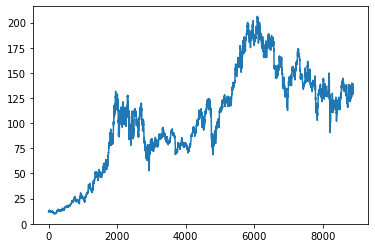

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

file = "IBM1day.csv"
df = pd.read_csv(file)
print(df[100:110])

df.fillna(inplace=True, method="ffill")
# df.set_index(df.Datetime, inplace=True)
close = df.Close.values
df["STD"] = (
    df.Close.rolling(30).std() / df.Close.rolling(30).mean()
)  # this will be used as a feature later on

# plt.xticks(np.arange(0, len(df)+1, 5000), rotation=45)
plt.plot(df.index, df.Close)
# plt.plot(df.STD)


Creating labels using CTL from my julialang package "FinanceTools", the function result begins and ends with "0" which i'll set to -1 since they aren't a defined class for the model. The "omega" is paramater for the labelling function, adjusting omega changes the sensitivity to trend changes.

Function for labels as written in Julia:
```
function trendlabel(x::AbstractArray, ω::Real)
    N = length(x) # paper uses N as length of vector
    t = collect(1:N) # paper uses this thing for some reason
    y = zeros(Int8, N) # initialise array containing labels
    #initialising stuff
    FP = x[1] # first price
    xₕ = x[1] # highest price as of yet
    xₗ = x[1] #lowest price as of yet
    HT = t[1] #time highest price was reached
    LT = t[1] #time the lowest price was reached
    Cid = 0 #direction of trend
    FP_N = 0 # index of first price for loop
    #alg starts here
    for i in 1:N
        if x[i] > FP + x[1] * ω
            xₕ, HT, FP_N, Cid = x[i], t[i], i, 1
            break
        end
        if x[i] < FP - x[1] * ω
            xₗ, LT, FP_N, Cid = x[i], t[i], i, -1
            break
        end
    end

    for i in FP_N+1:N
        # Trending down
        if Cid > 0
            if x[i] > xₕ
                xₕ, HT = x[i], t[i]
            end
            if x[i] < xₕ - xₕ * ω && LT ≤ HT
                for j in 1:N
                    if t[j] > LT && t[j] ≤ HT
                        y[j] = 1
                    end
                end
                xₗ, LT, Cid = x[i], t[i], -1
            end
        end
        # Trending up
        if Cid < 0
            if x[i] < xₗ
                xₗ, LT = x[i], t[i]
            end
            if x[i] > xₗ + xₗ * ω && HT ≤ LT
                for j in 1:N
                    if t[j] > HT && t[j] ≤ LT
                        y[j] = -1
                    end
                end
                xₕ, HT, Cid = x[i], t[i], 1
            end
        end
    end
    return (y)
end
```

[-1  1  1 ... -1 -1 -1]


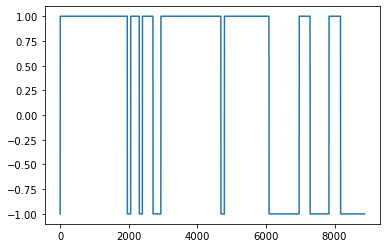

In [2]:
from julia import FinanceTools

omega = 0.3 # number can be adjusted but seems to work decently well on a large spectrum of stocks at about 0.1
labels = FinanceTools.trendlabel(close, omega)
labels[labels == 0] = -1  # replace all 0s with -1
print(labels)
plt.plot(labels)


I'll generate the close series feature. The series will be split up in windows of [[0:tslen], [1:tslen+1]...], the last few windows are NaN and are kept to preserve the shape of the array.

In [3]:
tslen = 10
timesamples = np.empty(shape=(len(close), tslen)) * np.nan
for i in range(len(close) - tslen):
    timesamples[i] = close[i : i + tslen]
print(timesamples)


[[12.01003838 12.30879498 12.57767677 ... 12.428298   12.63742828
  12.7569313 ]
 [12.30879498 12.57767677 12.45817375 ... 12.63742828 12.7569313
  12.48805046]
 [12.57767677 12.45817375 12.21916771 ... 12.7569313  12.48805046
  12.21916771]
 ...
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]]


/tmp/ipykernel_27364/4259757173.py:2: RuntimeWarning: invalid value encountered in multiply
  timesamples = np.empty(shape=(len(close), tslen)) * np.nan


Generating cumulative tick direction feature

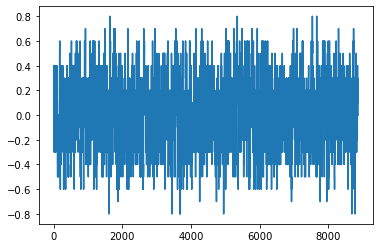

In [4]:
updownsamples = np.zeros((len(timesamples), 1))
for i, sample in enumerate(timesamples):
    lastj = sample[0]
    change = 0
    for j in sample:
        if j > lastj:
            change += 1
        elif j < lastj:
            change -= 1
        lastj = j
    updownsamples[i] = change / tslen

plt.plot(updownsamples)


Merging all of the generated features

In [5]:
samples = np.concatenate(
    (updownsamples, np.array(df.STD)[np.newaxis].T), axis=1
)
# feature names to be used later
feature_names = ["updown", "std"] + ["ts"] * tslen


Preprocessing the timeseries.


In [6]:
from sklearn.preprocessing import scale

# process the samples
print(len(labels), len(samples))
nanmask = np.isnan(samples).any(axis=1)
samples = samples[~nanmask, :]
labels = labels[~nanmask]

scale(samples, axis=1, copy=False)

print(f"Do the samples contain any NaNs? {np.any(np.isnan(samples))}")
print(samples[:2])


8876 8876
Do the samples contain any NaNs? False
[[-2.21799602 -2.25252682  0.42020084  0.43850853  0.48122692  0.50563743
   0.46902186  0.42020084  0.42020084  0.45681641  0.42630327  0.4324059 ]
 [-2.2384318  -2.23198266  0.44037465  0.48279924  0.50704186  0.47067812
   0.42219287  0.42219287  0.45855662  0.42825334  0.43431399  0.40401091]]


Generating T-Sne

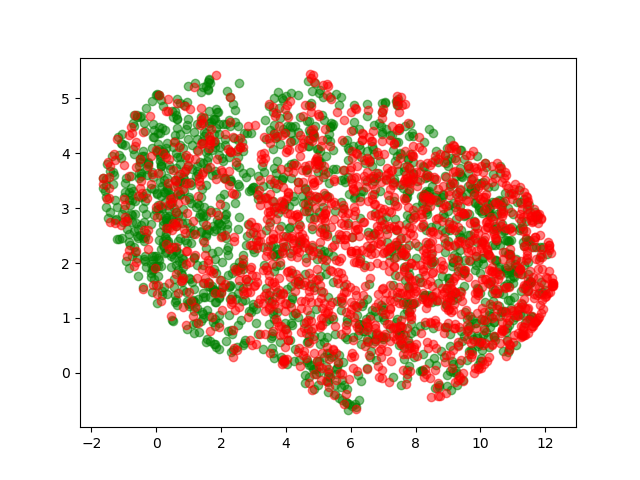

In [8]:
%matplotlib widget
import umap
reduced_x = umap.UMAP().fit_transform(samples)
i_buy = np.where(labels == 1)
i_sell = np.where(labels == -1)
buys = reduced_x[i_buy][:1500]
sells = reduced_x[i_sell][:1500]
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(buys.T[0], buys.T[1], color="green", alpha=0.5)
ax.scatter(sells.T[0], sells.T[1], color="red", alpha=0.5)

plt.show()


Splitting datasets into training and testing sets. "split" is the fraction of data that will be used for testing. Training data is shuffled and balanced so there is an equal amount of buy and sell samples.

In [ ]:
from sklearn.utils import shuffle

split = 0.5  # when to split training from testing

X_train, X_test = np.split(samples, [int(split * len(labels))])

y_train, y_test = np.split(labels, [int(split * len(labels))])

X_train, y_train = shuffle(X_train, y_train)
balance = sum(y_train)
i = 0
mask = []
if balance > 0:
    while balance > 0:
        if y_train[i] == 1:
            mask.append(i)
            balance -= 1
        i += 1
else:
    while balance < 0:
        if y_train[i] == -1:
            mask.append(i)
            balance += 1
        i += 1
X_train, y_train = np.delete(X_train, mask, axis=0), np.delete(y_train, mask, axis=0)
balance = sum(y_train)
print(f"balance of buys and sells, should be close to zero: {balance}")


balance of buys and sells, should be close to zero: 0


Creating SVM model, commented code was used to find parameters.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#model = RandomForestClassifier(n_estimators=600, n_jobs=-1) #Support vector machine gave better  results

# weights are manually adjusted to assure that the model prioritises accuracy in sells over buys
model = SVC(max_iter=-1, cache_size=1000, C=1e5, gamma="auto", kernel="poly", class_weight={1:2.2, -1:1}) 
params = {"C": [1e1, 1e2, 1e3, 1e4, 1e5], "kernel": ("linear", "rbf", "poly", "sigmoid")}
""" Enable this section to find the best paramters for the support vector machine,
it has been disabled due to the long processing time"""
run_test = False
if run_test:
    clf = GridSearchCV(model, params, n_jobs=-1, scoring="f1")
    clf.fit(X_train, y_train)
    print(f"Best params are: {clf.best_params_}")

model.fit(X_train, y_train)

guessed_labels = model.predict(X_test)


Confusion matrix is made from the guessed labels and compared to the true labels to confirm that the model has any noticable predictive power.


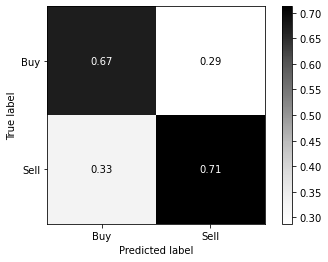

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, guessed_labels, labels=[1, -1], normalize="pred")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Buy", "Sell"]).plot(
    cmap="Greys"
)


              precision    recall  f1-score   support

         Buy      0.671     0.941     0.783      2746
        Sell      0.713     0.239     0.358      1668

    accuracy                          0.676      4414
   macro avg      0.692     0.590     0.571      4414
weighted avg      0.687     0.676     0.623      4414



<AxesSubplot:>

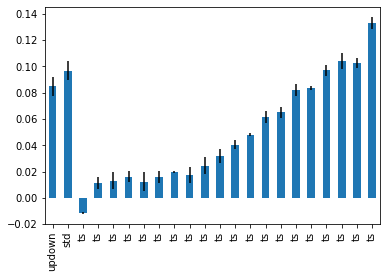

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report

print(
    classification_report(
        y_test, guessed_labels, digits=3, labels=[1, -1], target_names=["Buy", "Sell"]
    )
)

result = permutation_importance(model, X_test, y_test, n_repeats=4, n_jobs=-1)
# plot importances of features
forest_importances = pd.Series(result.importances_mean, index=feature_names)
forest_importances.plot.bar(yerr=result.importances_std)


In [ ]:
# no longer needed, does the same as classification report.
"""TP, FP, FN, TN = cm.flatten()
print(f"recall: {TP/(TP+FN)}")
TPR = TP / (TP+FN)
TNR = TN/(TN+FP)
print(f"adjusted precision: {(TPR+TNR)/2}")
"""


'TP, FP, FN, TN = cm.flatten()\nprint(f"recall: {TP/(TP+FN)}")\nTPR = TP / (TP+FN)\nTNR = TN/(TN+FP)\nprint(f"adjusted precision: {(TPR+TNR)/2}")\n'

In [ ]:
pd.DataFrame(dict(label=labels)).to_csv("IBMlabels.csv")
pd.DataFrame(dict(label=guessed_labels)).to_csv("GuessedIBMlabels.csv")
